# Sine-Gordon equation

* Physical space
\begin{align}
\phi_{tt} = \phi_{xx} - sin(\phi)
\end{align}
* Discretize equation on a Chebyshev polynomial grid
* $D$ is a differentiation matrix, $I$ is an identity matrix, and $0$ is a matrix of zeroes

\begin{equation}
\begin{bmatrix}
\phi \\ u
\end{bmatrix}_{t} = 
\begin{bmatrix}
0 & I \\
D^2 & 0
\end{bmatrix}
\begin{bmatrix}
\phi \\ u
\end{bmatrix} +
\begin{bmatrix}
0 \\ -sin(\phi)
\end{bmatrix}
\end{equation}

In [72]:
from rkstiff.etd35 import ETD35
from rkstiff.grids import construct_x_Dx_cheb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Linear and nonlinear operators

In [73]:
N = 100 # N Chebyshev polynomial degree (N+1 points)
a = 20 # grid end points
x,Dx = construct_x_Dx_cheb(N,-a,a) # x has length(N+1), Dx is a matrix of size (N+1) x (N+1)

# Discretize and propagate on interior Chebyshev points, enforce B.C. explicitly
x_interior = x[1:-1]
nx = len(x_interior) 

D = Dx.dot(Dx)[1:-1,1:-1] # differentiate on interior points
I = np.eye(nx) 
Z = np.zeros(shape=(nx,nx))
L1 = np.c_[Z,I]
L2 = np.c_[D,Z]
linop = np.r_[L1,L2]

def NL_kink(w):
    u = w[:nx].real # u in first N-1 components of w, the derivate of u is in the last N-1 components
    return np.r_[np.zeros(nx),-np.sin(u+(x_interior+a)*np.pi/a)]

def NL_antikink(w):
    u = w[:nx].real
    return np.r_[np.zeros(nx),-np.sin(u+np.pi*(a-x_interior)/a)]

def NL_kink_kink(w):
    u = w[:nx].real
    return np.r_[np.zeros(nx),-np.sin(u+2*(x_interior+a)*np.pi/a)]

def NL_kink_antikink(w):
    u = w[:nx].real
    return np.r_[np.zeros(nx),-np.sin(u+2*np.pi)]

# Initial value profiles

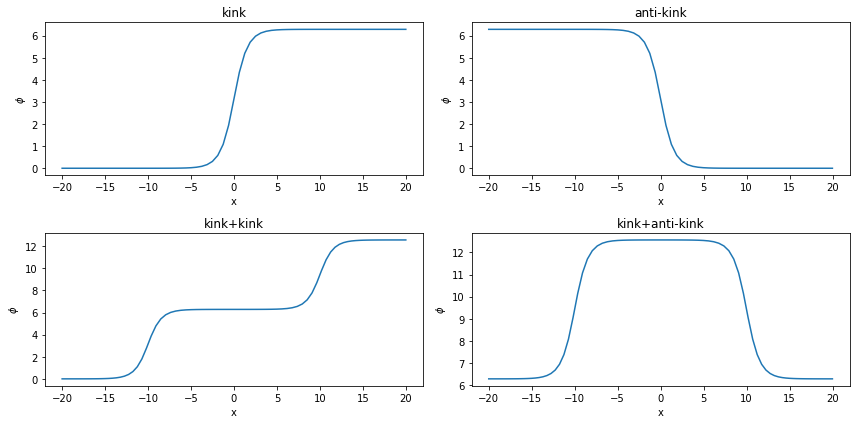

In [74]:
# kink solitons of form 4tan^{-1}(F(x)/G(t)), with F(x;v) = exp(...), G(t;v) = exp(...) 
# here they are evaluated at zero for the initial profile

v = 0.2
psi0_kink = 4*np.arctan(np.exp(x_interior/np.sqrt(1-v**2)))
dpsi0_kink = (-2*v/np.sqrt(1-v**2))/np.cosh(x_interior/np.sqrt(1-v**2)) 

psi0_antikink = 4*np.arctan(np.exp(-x_interior/np.sqrt(1-v**2)))
dpsi0_antikink = (-2*v/np.sqrt(1-v**2))/np.cosh(x_interior/np.sqrt(1-v**2))

psi0_kink_kink = 4*np.arctan(np.exp( (x_interior+a/2)/np.sqrt(1-v**2))) + \
        4*np.arctan(np.exp( (x_interior-a/2) /np.sqrt(1-v**2)))
dpsi0_kink_kink = -2*v/(np.cosh((x_interior+a/2)/np.sqrt(1-v**2))*np.sqrt(1-v**2)) + \
     2*v/(np.cosh((x_interior-a/2)/np.sqrt(1-v**2))*np.sqrt(1-v**2))

psi0_kink_antikink = 4*np.arctan(np.exp( (x_interior+a/2) /np.sqrt(1-v**2))) + \
        4*np.arctan(np.exp( -(x_interior-a/2) /np.sqrt(1-v**2))) 
dpsi0_kink_antikink = -2*v/(np.cosh((x_interior+a/2)/np.sqrt(1-v**2))*np.sqrt(1-v**2)) + \
     -2*v/(np.cosh((x_interior-a/2)/np.sqrt(1-v**2))*np.sqrt(1-v**2))

IVP = [psi0_kink,psi0_antikink,psi0_kink_kink,psi0_kink_antikink]
labels = ['kink','anti-kink','kink+kink','kink+anti-kink']

fig = plt.figure(figsize=(12,6))
for i,soliton in enumerate(IVP):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(x[1:-1],soliton)
    ax.set_title(labels[i])
    ax.set_xlabel('x')
    ax.set_ylabel('$\phi$')
plt.tight_layout()

# Transform boundaries to zeroes

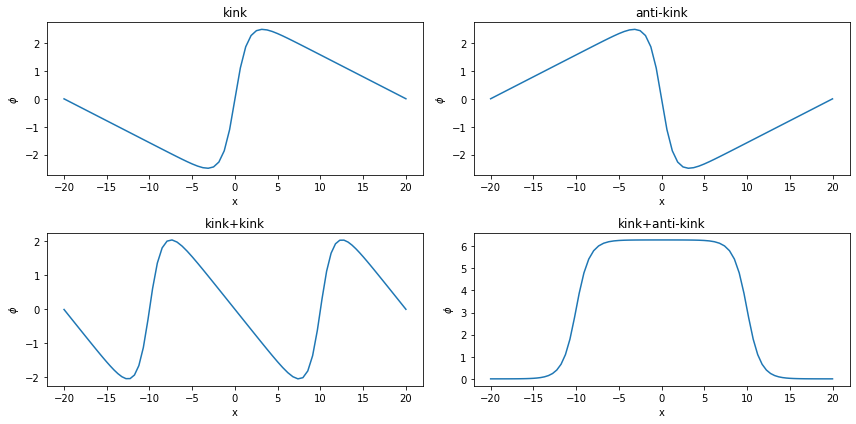

In [75]:
psi0_kink = psi0_kink - (x_interior+a)*np.pi/a
psi0_antikink = psi0_antikink  - (a - x_interior)*np.pi/a
psi0_kink_kink = psi0_kink_kink - 2*(x_interior+a)*np.pi/a
psi0_kink_antikink = psi0_kink_antikink - 2*np.pi

IVP = [psi0_kink,psi0_antikink,psi0_kink_kink,psi0_kink_antikink]
labels = ['kink','anti-kink','kink+kink','kink+anti-kink']

fig = plt.figure(figsize=(12,6))
for i,soliton in enumerate(IVP):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(x[1:-1],soliton)
    ax.set_title(labels[i])
    ax.set_xlabel('x')
    ax.set_ylabel('$\phi$')
plt.tight_layout()

# Propagate with ETD35

In [76]:
tf = 80
params = {'epsilon': 1e-4, 'contour_radius' : 1, 'contour_points' : 32, 'diagonalize' : True  }
solver_kink = ETD35(linop=linop,NLfunc=NL_kink,**params)
solver_antikink = ETD35(linop=linop,NLfunc=NL_antikink,**params)
solver_kink_kink = ETD35(linop=linop,NLfunc=NL_kink_kink,**params)
solver_kink_antikink = ETD35(linop=linop,NLfunc=NL_kink_antikink,**params)


solver_kink.evolve(np.r_[psi0_kink,dpsi0_kink],t0=0,tf=tf)
solver_antikink.evolve(np.r_[psi0_antikink,dpsi0_antikink],t0=0,tf=tf)
solver_kink_kink.evolve(np.r_[psi0_kink_kink,dpsi0_kink_kink],t0=0,tf=tf)
_ = solver_kink_antikink.evolve(np.r_[psi0_kink_antikink,dpsi0_kink_antikink],t0=0,tf=tf)


            method may be unstable
            method may be unstable
            method may be unstable
            method may be unstable


# Recover boundaries and process for graphing

In [77]:
Ukink = []
for wv in solver_kink.u:
    wint = wv[:nx].real
    uint = wint + (x_interior+a)*np.pi/a
    u = np.r_[0,uint,2*np.pi]
    Ukink.append(u)
Ukink = np.array(Ukink); 
t = np.array(solver_kink.t)
Tkink,Xkink = np.meshgrid(t,x,indexing='ij')
    
Uantikink = []
for wv in solver_antikink.u:
    wint = wv[:nx].real
    uint = wint + (a - x_interior)*np.pi/a
    u = np.r_[2*np.pi,uint,0]
    Uantikink.append(u)
Uantikink = np.array(Uantikink)
t = np.array(solver_antikink.t)
Tantikink,Xantikink = np.meshgrid(t,x,indexing='ij')

Ukink_kink = []
for wv in solver_kink_kink.u:
    wint = wv[:nx].real
    uint = wint + (x_interior+a)*2*np.pi/a
    u = np.r_[0,uint,4*np.pi]
    Ukink_kink.append(u)
Ukink_kink = np.array(Ukink_kink); 
t = np.array(solver_kink_kink.t)
Tkink_kink,Xkink_kink = np.meshgrid(t,x,indexing='ij')
    
Ukink_antikink = []
for wv in solver_kink_antikink.u:
    wint = wv[:nx].real
    uint = wint + 2*np.pi
    u = np.r_[2*np.pi,uint,2*np.pi]
    Ukink_antikink.append(u)
Ukink_antikink = np.array(Ukink_antikink)
t = np.array(solver_kink_antikink.t)
Tkink_antikink,Xkink_antikink = np.meshgrid(t,x,indexing='ij')

# Plot results

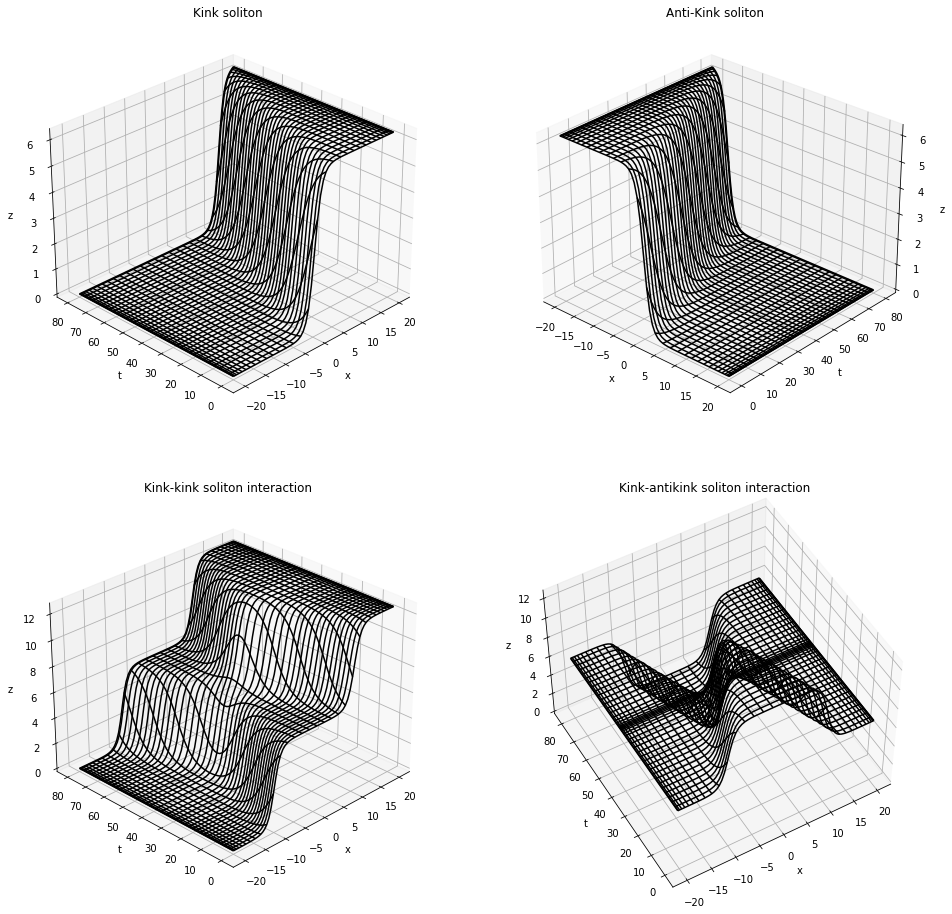

In [78]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(2,2,1,projection='3d')
ax.plot_wireframe(Xkink,Tkink,Ukink,color='black')
ax.view_init(elev=28,azim=-135)
ax.set_title('Kink soliton')
ax = fig.add_subplot(2,2,2,projection='3d')
ax.plot_wireframe(Xantikink,Tantikink,Uantikink,color='black')
ax.view_init(elev=28,azim=-48)
ax.set_title('Anti-Kink soliton')
ax = fig.add_subplot(2,2,3,projection='3d')
ax.plot_wireframe(Xkink_kink,Tkink_kink,Ukink_kink,color='black')
ax.view_init(elev=28,azim=-135)
ax.set_title('Kink-kink soliton interaction')
ax = fig.add_subplot(2,2,4,projection='3d')
ax.plot_wireframe(Xkink_antikink,Tkink_antikink,Ukink_antikink,color='black')
ax.view_init(elev=50,azim=-120)
ax.set_title('Kink-antikink soliton interaction')

for ax in fig.axes:
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('z')
    ax.set_facecolor('white')

